# Topic:        Challenge Set 1
# Subject:      Explore MTA turnstile data
# Date:         01/23/2017
# Name:         Rosie Hoyem

### Challenge 1

Download a few MTA turnstile data files
Open up a file, use csv reader to read it, make a python dict where there is a key for each (C/A, UNIT, SCP, STATION). These are the first four columns. The value for this key should be a list of lists. Each list in the list is the rest of the columns in a row. For example, one key-value pair should look like:

{ ('A002','R051','02-00-00','LEXINGTON AVE'): [ ['NQR456', 'BMT', '01/03/2015', '03:00:00', 'REGULAR', '0004945474', '0001675324'], ['NQR456', 'BMT', '01/03/2015', '07:00:00', 'REGULAR', '0004945478', '0001675333'], ['NQR456', 'BMT', '01/03/2015', '11:00:00', 'REGULAR', '0004945515', '0001675364'], ... ] }

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Image

# enables inline plots, without it plots don't show up in the notebook
%matplotlib inline

In [21]:
df1 = pd.read_csv('data/turnstile_160507.txt')
df2 = pd.read_csv('data/turnstile_160514.txt')
df3 = pd.read_csv('data/turnstile_160521.txt')
df4 = pd.read_csv('data/turnstile_160528.txt')
frames = [df1, df2, df3, df4]
df_4wk = pd.concat(frames)

df_4wk.columns =['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS']

df_4wk.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

In [25]:
df = df_4wk[(df_4wk['STATION'] == '1 AV') | (df_4wk['STATION'] == '23 ST') | (df_4wk['STATION'] == '96 ST')]
len(df)

19892

# Challenge 2

Let's turn this into a time series.

For each key (basically the control area, unit, device address and station of a specific turnstile), have a list again, but let the list be comprised of just the point in time and the count of entries.

This basically means keeping only the date, time, and entries fields in each list. You can convert the date and time into datetime objects -- That is a python class that represents a point in time. You can combine the date and time fields into a string and use the dateutil module to convert it into a datetime object. For an example check this StackOverflow question.

Your new dict should look something like

{ ('A002','R051','02-00-00','LEXINGTON AVE'): [ [datetime.datetime(2013, 3, 2, 3, 0), 3788], [datetime.datetime(2013, 3, 2, 7, 0), 2585], [datetime.datetime(2013, 3, 2, 12, 0), 10653], [datetime.datetime(2013, 3, 2, 17, 0), 11016], [datetime.datetime(2013, 3, 2, 23, 0), 10666], [datetime.datetime(2013, 3, 3, 3, 0), 10814], [datetime.datetime(2013, 3, 3, 7, 0), 10229], ... ], .... }

In [26]:
import dateutil.parser

df['date_time'] = df['DATE'] + " " + df['TIME']

parse_time = lambda x: dateutil.parser.parse(x, dayfirst=False)
df['date_time'] = df['date_time'].apply(parse_time)

df.head()

/Users/rosiehoyem/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/rosiehoyem/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,date_time
4026,A030,R083,01-00-00,23 ST,NR,BMT,04/30/2016,00:00:00,REGULAR,5406716,3395122,2016-04-30 00:00:00
4027,A030,R083,01-00-00,23 ST,NR,BMT,04/30/2016,04:00:00,REGULAR,5406798,3395136,2016-04-30 04:00:00
4028,A030,R083,01-00-00,23 ST,NR,BMT,04/30/2016,08:00:00,REGULAR,5406816,3395215,2016-04-30 08:00:00
4029,A030,R083,01-00-00,23 ST,NR,BMT,04/30/2016,12:00:00,REGULAR,5406952,3395411,2016-04-30 12:00:00
4030,A030,R083,01-00-00,23 ST,NR,BMT,04/30/2016,16:00:00,REGULAR,5407360,3395611,2016-04-30 16:00:00


# Challenge 3

These counts are for every n hours. (What is n?) We want total daily entries.
Now make it that we again have the same keys, but now we have a single value for a single day, which is the total number of passengers that entered through this turnstile on this day.

In [27]:
df['diffEntries'] = df.ENTRIES.diff()
df['diffExits'] = df.EXITS.diff()
df['machine_change'] = (df.SCP != df.SCP.shift())
dfrei = df.reset_index(drop=True)
df = dfrei
df.diffEntries[df.index[df.machine_change==True]] = 0
df.diffExits[df.index[df.machine_change==True]] = 0
df['counterReset'] = ((df.diffEntries > 6000) | (df.diffEntries < 0) | (df.diffExits > 6000) | (df.diffExits < 0))
df.diffExits[df.index[df.counterReset==True]] = 0
df.diffEntries[df.index[df.counterReset==True]] = 0

df.head()

/Users/rosiehoyem/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/rosiehoyem/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/rosiehoyem/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,date_time,diffEntries,diffExits,machine_change,counterReset
0,A030,R083,01-00-00,23 ST,NR,BMT,04/30/2016,00:00:00,REGULAR,5406716,3395122,2016-04-30 00:00:00,0.0,0.0,True,False
1,A030,R083,01-00-00,23 ST,NR,BMT,04/30/2016,04:00:00,REGULAR,5406798,3395136,2016-04-30 04:00:00,82.0,14.0,False,False
2,A030,R083,01-00-00,23 ST,NR,BMT,04/30/2016,08:00:00,REGULAR,5406816,3395215,2016-04-30 08:00:00,18.0,79.0,False,False
3,A030,R083,01-00-00,23 ST,NR,BMT,04/30/2016,12:00:00,REGULAR,5406952,3395411,2016-04-30 12:00:00,136.0,196.0,False,False
4,A030,R083,01-00-00,23 ST,NR,BMT,04/30/2016,16:00:00,REGULAR,5407360,3395611,2016-04-30 16:00:00,408.0,200.0,False,False


In [28]:
df.set_index(['C/A','UNIT','SCP','STATION'])

df_gr3 = df.groupby(['C/A', 'UNIT','STATION','SCP','DATE'], as_index=False).sum()

df_gr3.head()

,C/A,UNIT,STATION,SCP,DATE,ENTRIES,EXITS,diffEntries,diffExits,machine_change,counterReset
0,A030,R083,23 ST,01-00-00,04/30/2016,32442540,20372286,1182.0,669.0,1.0,0.0
1,A030,R083,23 ST,01-00-00,05/01/2016,32450981,20376614,1218.0,656.0,0.0,0.0
2,A030,R083,23 ST,01-00-00,05/02/2016,32458773,20382194,1831.0,1329.0,0.0,0.0
3,A030,R083,23 ST,01-00-00,05/03/2016,43294031,27187325,2018.0,1408.0,0.0,0.0
4,A030,R083,23 ST,01-00-00,05/04/2016,32483174,20398968,2143.0,1430.0,0.0,0.0


# Challenge 4

Take the list of [(date1, count1), (date2, count2), ...], for the turnstile and turn it into two lists: dates and counts. This should plot it:

```
plt.figure(figsize=(10,3))
plt.plot(dates,counts)
```

In [29]:
df['date_object'] = df['DATE'].apply(parse_time)
df_gr4 = df.groupby(['C/A', 'UNIT','STATION','SCP','date_object'], as_index=False).sum()
df_gr4.head()

,C/A,UNIT,STATION,SCP,date_object,ENTRIES,EXITS,diffEntries,diffExits,machine_change,counterReset
0,A030,R083,23 ST,01-00-00,2016-04-30,32442540,20372286,1182.0,669.0,1.0,0.0
1,A030,R083,23 ST,01-00-00,2016-05-01,32450981,20376614,1218.0,656.0,0.0,0.0
2,A030,R083,23 ST,01-00-00,2016-05-02,32458773,20382194,1831.0,1329.0,0.0,0.0
3,A030,R083,23 ST,01-00-00,2016-05-03,43294031,27187325,2018.0,1408.0,0.0,0.0
4,A030,R083,23 ST,01-00-00,2016-05-04,32483174,20398968,2143.0,1430.0,0.0,0.0


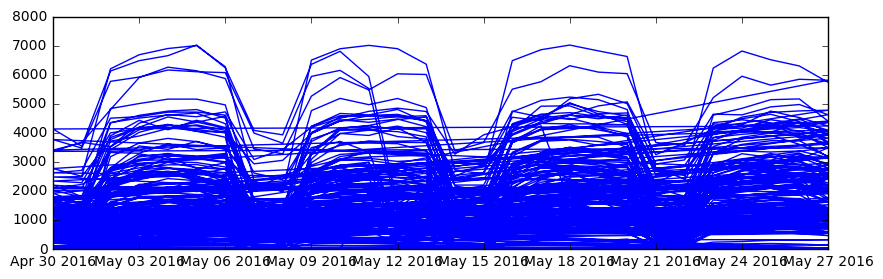

In [30]:
dates = df_gr4['date_object']
counts = df_gr4['diffEntries']
plt.figure(figsize=(10,3))
plt.plot(dates,counts);

# Challenge 5

So far we've been operating on a single turnstile level, let's combine turnstiles in the same ControlArea/Unit/Station combo. There are some ControlArea/Unit/Station groups that have a single turnstile, but most have multiple turnstilea-- same value for the C/A, UNIT and STATION columns, different values for the SCP column.
We want to combine the numbers together -- for each ControlArea/UNIT/STATION combo, for each day, add the counts from each turnstile belonging to that combo.

In [31]:
df_gr5 = df.groupby(['C/A', 'UNIT','STATION','date_object'], as_index=False).sum()
df_gr5.head()

,C/A,UNIT,STATION,date_object,ENTRIES,EXITS,diffEntries,diffExits,machine_change,counterReset
0,A030,R083,23 ST,2016-04-30,754975337,109888648,7849.0,3781.0,8.0,0.0
1,A030,R083,23 ST,2016-05-01,755030560,109912149,7638.0,3204.0,0.0,0.0
2,A030,R083,23 ST,2016-05-02,755085051,109941036,15176.0,7081.0,0.0,0.0
3,A030,R083,23 ST,2016-05-03,1006913141,146647722,17316.0,7664.0,0.0,0.0
4,A030,R083,23 ST,2016-05-04,755292612,110031158,18199.0,7687.0,0.0,0.0


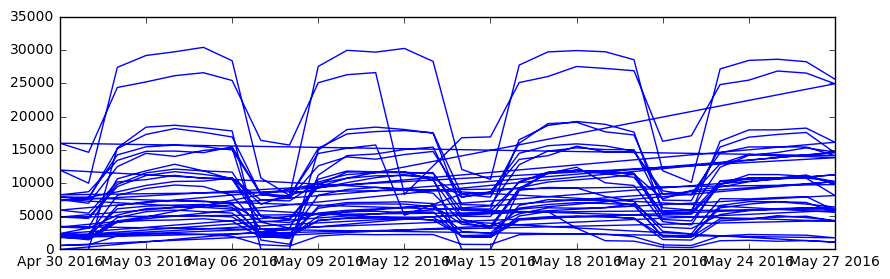

In [32]:
dates = df_gr5['date_object']
counts = df_gr5['diffEntries']
plt.figure(figsize=(10,3))
plt.plot(dates,counts);

# Challenge 6
Similarly, combine everything in each station, and come up with a time series of [(date1, count1),(date2,count2),...] type of time series for each STATION, by adding up all the turnstiles in a station.

In [33]:
df_gr6 = df.groupby(['STATION', 'date_object'], as_index=False).sum()

df_gr6.head()

,STATION,date_object,ENTRIES,EXITS,diffEntries,diffExits,machine_change,counterReset
0,1 AV,2016-04-30,9365210271,20854612574,15547.0,13313.0,10.0,5.0
1,1 AV,2016-05-01,9365326117,20854690837,16527.0,14448.0,0.0,6.0
2,1 AV,2016-05-02,10251131526,21725423983,22073.0,18091.0,0.0,6.0
3,1 AV,2016-05-03,9365572701,20854843128,24412.0,19298.0,0.0,6.0
4,1 AV,2016-05-04,9365722761,20854931387,25047.0,20645.0,0.0,6.0


# Challenge 7
Plot the time series for a station.

In [36]:
df_1av = df[(df['STATION'] == '1 AV')]
df_1av_gr = df_1av.groupby(['STATION', 'date_object'], as_index=False).sum()
df_1av_gr.head()

,STATION,date_object,ENTRIES,EXITS,diffEntries,diffExits,machine_change,counterReset
0,1 AV,2016-04-30,9365210271,20854612574,15547.0,13313.0,10.0,5.0
1,1 AV,2016-05-01,9365326117,20854690837,16527.0,14448.0,0.0,6.0
2,1 AV,2016-05-02,10251131526,21725423983,22073.0,18091.0,0.0,6.0
3,1 AV,2016-05-03,9365572701,20854843128,24412.0,19298.0,0.0,6.0
4,1 AV,2016-05-04,9365722761,20854931387,25047.0,20645.0,0.0,6.0


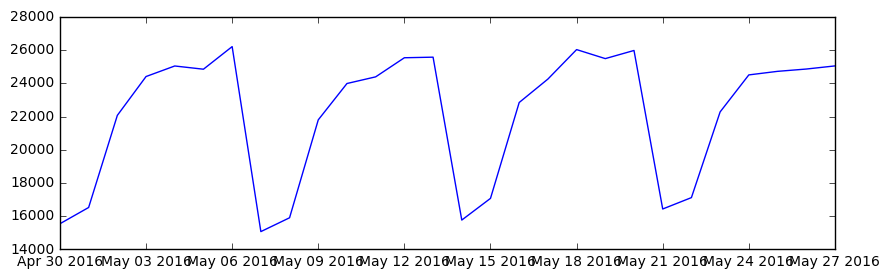

In [35]:
dates = df_1av_gr['date_object']
counts = df_1av_gr['diffEntries']
plt.figure(figsize=(10,3))
plt.plot(dates,counts);

# Challenge 8
Make one list of counts for one week for one station. Monday's count, Tuesday's count, etc. so it's a list of 7 counts. Make the same list for another week, and another week, and another week. plt.plot(week_count_list) for every week_count_list you created this way. You should get a rainbow plot of weekly commute numbers on top of each other.

In [69]:
import datetime as dt

df_1av = df[(df['STATION'] == '1 AV')]

df_1av['dayofweek'] = df_1av['date_object'].dt.dayofweek
df_1av['weekofyear'] = df_1av['date_object'].dt.week

df_1av_gr = df_1av.groupby(['weekofyear','dayofweek']).sum()

df_1av_gr


/Users/rosiehoyem/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/rosiehoyem/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ENTRIES        EXITS  diffEntries  diffExits  \
weekofyear dayofweek                                                     
17         5           9365210271  20854612574      15547.0    13313.0   
           6           9365326117  20854690837      16527.0    14448.0   
18         0          10251131526  21725423983      22073.0    18091.0   
           1           9365572701  20854843128      24412.0    19298.0   
           2           9365722761  20854931387      25047.0    20645.0   
           3           9365875888  20855022185      24853.0    20559.0   
           4           9366033060  20855116207      26214.0    21354.0   
           5           9366179265  20855202758      15074.0    13034.0   
           6           9366291088  20855273425      15907.0    13627.0   
19         0           9366390245  20855345667      21804.0    19077.0   
           1          12488702611  27807241359      23992.0    19624.0   
           2          12488904605  27807363898      24393.0    19773.0   
           3           9809816269  21291025432      25543.0    19948.0   
           4           9366989115  20855702595      25578.0    21815.0   
           5           9367138300  20855790078      15769.0    13705.0   
           6           9367253488  20855867528      17075.0    15059.0   
20         0           9367361891  20855942781      22848.0    19075.0   
           1           9367507963  20856029814      24259.0    20094.0   
           2           8924604556  20420658369      26034.0    20971.0   
           3           9367818932  20856214358      25491.0    20608.0   
           4           9367976537  20856308054      25981.0    21310.0   
           5           9368130897  20856397558      16436.0    14180.0   
           6           9368251247  20856475256      17121.0    14395.0   
21         0           9368356378  20856547887      22281.0    19054.0   
           1           9368501316  20856633554      24510.0    19372.0   
           2           9368652160  20856721862      24724.0    19861.0   
           3           9368805113  20856810913      24863.0    19816.0   
           4           9368957498  20856898674      25051.0    19951.0   

                      machine_change  counterReset  
weekofyear dayofweek                                
17         5                    10.0           5.0  
           6                     0.0           6.0  
18         0                     0.0           6.0  
           1                     0.0           6.0  
           2                     0.0           6.0  
           3                     0.0           6.0  
           4                     0.0           6.0  
           5                    10.0           5.0  
           6                     0.0           6.0  
19         0                     0.0           6.0  
           1                     0.0           8.0  
           2                     0.0           8.0  
           3                     0.0           6.0  
           4                     0.0           6.0  
           5                    10.0           5.0  
           6                     0.0           6.0  
20         0                     0.0           6.0  
           1                     0.0           6.0  
           2                     0.0           6.0  
           3                     0.0           6.0  
           4                     0.0           6.0  
           5                    10.0           5.0  
           6                     0.0           6.0  
21         0                     0.0           6.0  
           1                     0.0           6.0  
           2                     0.0           6.0  
           3                     0.0           6.0  
           4                     0.0           6.0

In [70]:
dates = df_1av_gr['day_of_week']
counts = df_1av_gr['diffEntries']

plt.plot(dates,counts);

# No idea.

KeyError: 'day_of_week'

# Challenge 9

Over multiple weeks, sum total ridership for each station and sort them, so you can find out the stations with the highest traffic during the time you investigate

In [46]:
df1 = pd.read_csv('data/turnstile_160507.txt')
df2 = pd.read_csv('data/turnstile_160514.txt')
df3 = pd.read_csv('data/turnstile_160521.txt')
df4 = pd.read_csv('data/turnstile_160528.txt')
frames = [df, df2, df3, df4]
df_agg = pd.concat(frames)

df_agg['diffEntries'] = df_agg.ENTRIES.diff()
df_agg['diffExits'] = df_agg.EXITS.diff()
df_agg['machine_change'] = (df_agg.SCP != df_agg.SCP.shift())
dfrei = df_agg.reset_index(drop=True)
df_agg = dfrei
df_agg.diffEntries[df_agg.index[df_agg.machine_change==True]] = 0
df_agg.diffExits[df_agg.index[df_agg.machine_change==True]] = 0
df_agg['counterReset'] = ((df_agg.diffEntries > 6000) | (df_agg.diffEntries < 0) | (df_agg.diffExits > 6000) | (df_agg.diffExits < 0))
df_agg.diffExits[df_agg.index[df_agg.counterReset==True]] = 0
df_agg.diffEntries[df_agg.index[df_agg.counterReset==True]] = 0

df.head()

df_agg_gr = df_agg.groupby(['STATION'], as_index=False).sum()
sort_df_agg_gr = df_agg_gr.sort_values("ENTRIES")
sort_df_agg_gr.head(1)

/Users/rosiehoyem/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/rosiehoyem/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/rosiehoyem/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/rosiehoyem/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main

,STATION,ENTRIES,EXITS,EXITS,counterReset,diffEntries,diffExits,machine_change
312,PATH WTC 2,31197765,NaN,347332051.0,2.0,12314.0,0.0,3.0


# Challenge 10

Make a single list of these total ridership values and plot it with

plt.hist(total_ridership_counts)

to get an idea about the distribution of total ridership among different stations.

This should show you that most stations have a small traffic, and the histogram bins for large traffic volumes have small bars.

(array([ 332.,   25.,    8.,    2.,    2.,    1.,    0.,    0.,    0.,    1.]),
 array([  3.11977650e+07,   1.94997372e+11,   3.89963546e+11,
          5.84929720e+11,   7.79895894e+11,   9.74862068e+11,
          1.16982824e+12,   1.36479442e+12,   1.55976059e+12,
          1.75472676e+12,   1.94969294e+12]),
 <a list of 10 Patch objects>)

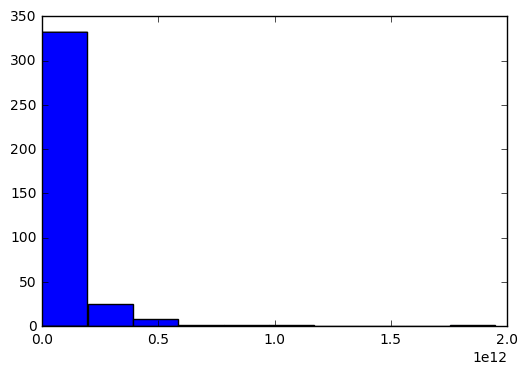

In [47]:
plt.hist(df_agg_gr['ENTRIES'])